# HSE 2024: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [11]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

$$\nabla_w L(w) = \sum_{i=1}^{N} (\sigma(w^\top x_i) - y_i) x_i + \gamma , \text{sign}(w) + 2 \beta w$$
$$\nabla_{w_0} L(w, w_0) = \sum_{i=1}^{N} (\sigma(w^\top x_i + w_0) - y_i)$$

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [12]:
def loss(X, y, w: List[float], gamma=1., beta=1.) -> float:
    w = np.array(w)

    l1 = gamma * beta * np.sum(np.abs(w))
    l2 = gamma * (1 - beta) * np.sum(w**2)
    
    return mse + l1 + l2

#### 3. [0.25 points] Implement the gradient (as a function)

In [13]:
def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> Tuple[List[float], float]:
    w = np.array(w)
    n = X.shape[0]
    
    predictions =  1 / (1 + np.exp(-X.dot(w)))
    grad_w = np.dot(X.T, predictions - y) + gamma * np.sign(w) + 2 * beta * w
    
    return grad_w


#### Check yourself

In [14]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)

grad_w = get_grad(X, y, w)
assert(np.allclose(grad_w,
                   [-3.99447493, -1.84786723,  0.64520104,  1.67059973, -5.03858487, -5.21496336],
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [15]:
from sklearn.base import BaseEstimator, ClassifierMixin

```
np.random.seed(self.random_state)
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.w = np.random.randn(X.shape[1])
```
Фиксируем random_state, добавляем bias и случайные веса.

---
```
y_pred = self.predict_proba(X)
error = y_pred - y

gradient = np.dot(X.T, error) / y.size + self.beta * np.sign(self.w) + self.gamma * self.w

w_prev = self.w.copy()
self.w -= self.learning_rate * gradient

elastic_net = self.beta * np.sum(np.abs(self.w)) + self.gamma * np.sum(self.w ** 2)
loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) + elastic_net
```
Высчитываем предикты, градиент. Копируем веса для проверки изменчивости и обновляем их. Высчитываем loss.

```
if np.linalg.norm(self.w - w_prev, ord=1) < self.tolerance:
    break
            
history.append(loss)
```
Проверяем изменение весов модели, если меньше значения tolerance, значит веса стали изменяться совсем немного, останавливаем цикл. 

Убрал BaseEstimator и ClassifierMixin чтобы класс можно было использовать в задаче с GridSearchCV. 

In [16]:
class Logit:
    def __init__(self, beta=1.0, gamma=1.0, lr=0.5, tolerance=0.01, max_iter=1000, random_state=42):
        self.beta = beta 
        self.gamma = gamma  
        self.lr = lr 
        self.tolerance = tolerance  
        self.max_iter = max_iter 
        self.random_state = random_state
        self.w = None
        self.history = None
        # you may additional properties if you wish

    def get_params(self, deep=True):
        return {
            'beta': self.beta,
            'gamma': self.gamma,
            'lr': self.lr,
            'tolerance': self.tolerance,
            'max_iter': self.max_iter,
            'random_state': self.random_state
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

    def fit(self, X, y):
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps
        
        np.random.seed(self.random_state)
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.w = np.random.randn(X.shape[1])

        history = []
        for i in range(self.max_iter):
            lm = np.dot(X, self.w)
            y_pred =  1 / (1 + np.exp(-lm))
            
            error = y_pred - y
            gradient = np.dot(X.T, error) / y.size + self.beta * np.sign(self.w) + self.gamma * self.w

            w_prev = self.w.copy()
            self.w -= self.lr * gradient

            elastic_net = self.beta * np.sum(np.abs(self.w)) + self.gamma * np.sum(self.w ** 2)
            loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) + elastic_net

            if np.linalg.norm(self.w - w_prev, ord=1) < self.tolerance:
                break

            history.append(loss)
        self.history = history
        return self

    def predict(self, X):
        # return vector of predicted labels (0 or 1) for each object from X
        # your code here
        predict = (self.predict_proba(X) >= 0.5).astype(int)
        return predict
                
    def predict_proba(self, X):
        # return vector of probabilities for each object from X

        # Для применения этой функции как для этой задачи, так и для задачи с GridSearchCV
        if X.shape[1] == self.w.shape[0] - 1:
            X = np.hstack((np.ones((X.shape[0], 1)), X))
        return  1 / (1 + np.exp(-np.dot(X, self.w)))

In [17]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [18]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

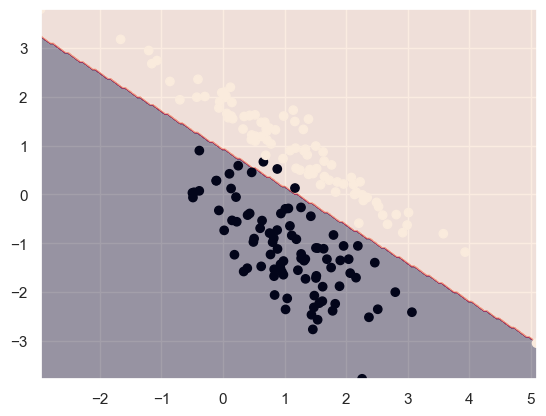

In [19]:
model = Logit(0, 0)
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

Text(0.5, 1.0, 'Loss during model training')

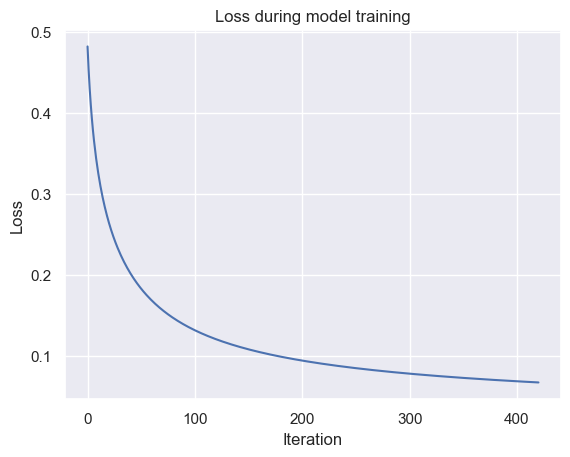

In [20]:
history = model.history
plt.plot(history, linestyle='-', label='Values')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss during model training')

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

kernels = ['linear', 'poly', 'rbf']
results = {kernel: {'accuracy': [], 'roc_auc': [], 'f1': []} for kernel in kernels}

regularization = [0.1, 1, 10, 100]
degrees = [2, 3, 4]
gammas = [0.1, 1, 3]

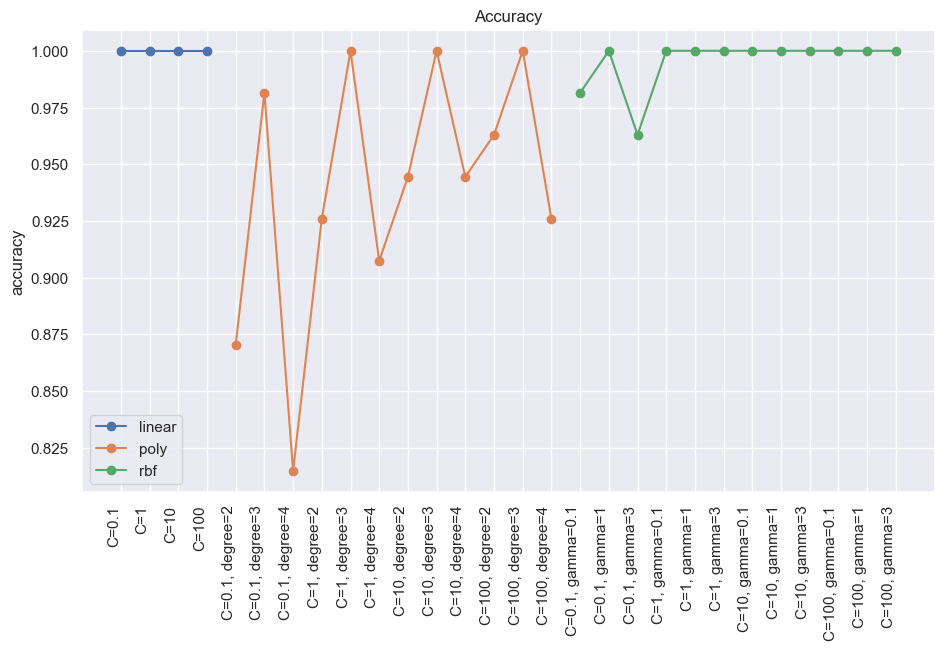

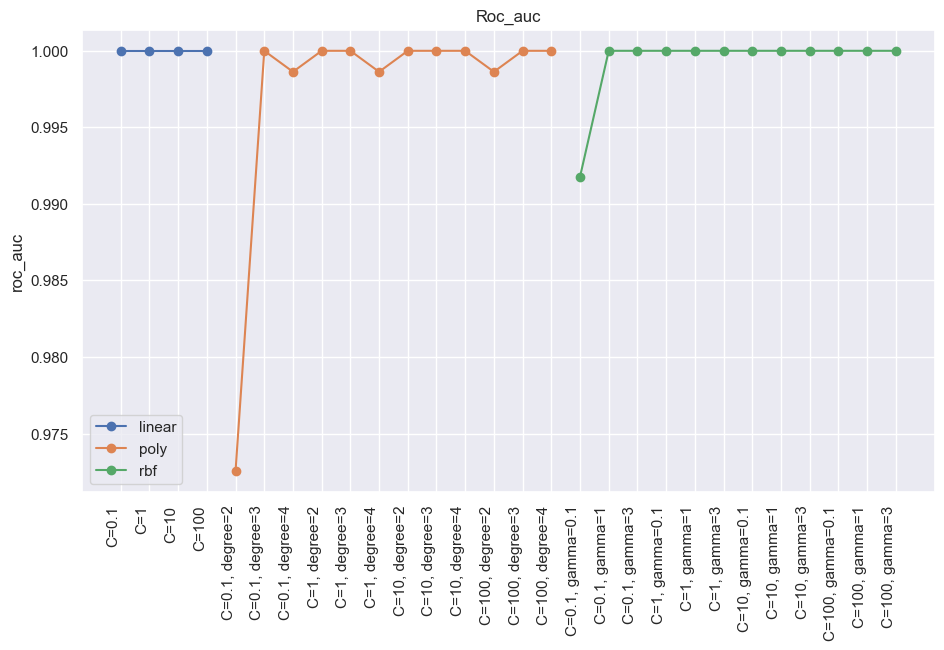

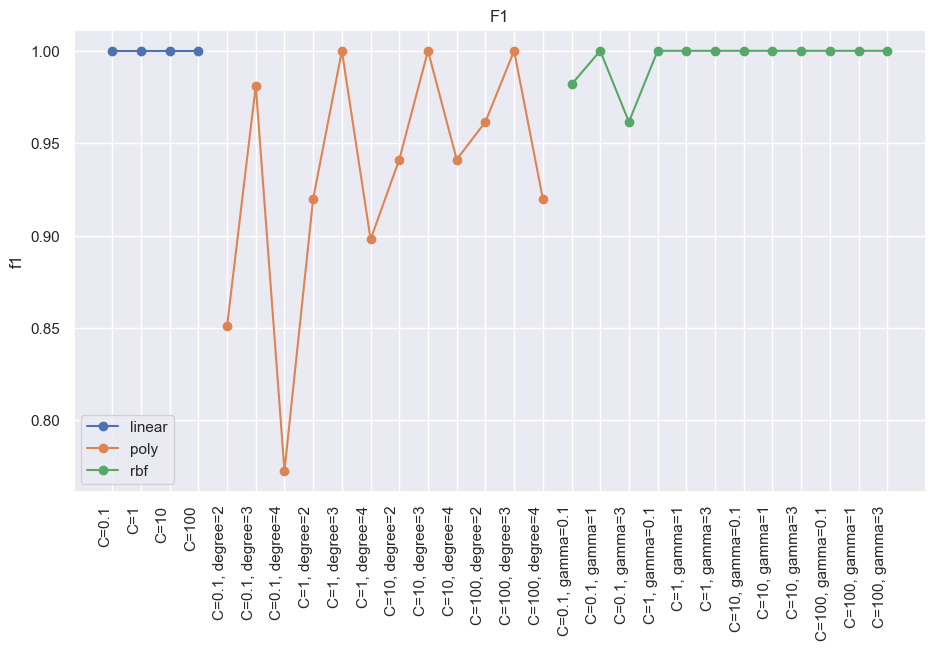

In [22]:
def fit_and_pred(model, label, kernel):
    model.fit(X_train, y_train)
            
    y_pred = model.predict(X_test)
    y_proba = model.decision_function(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    if kernel in results:
        results[kernel]['accuracy'].append((label, accuracy))
        results[kernel]['roc_auc'].append((label, roc_auc))
        results[kernel]['f1'].append((label, f1))

for reg_value in regularization:
    for degree in degrees:
        model = SVC(kernel='poly', C=reg_value, degree=degree, random_state=42)
        label = f"C={reg_value}, degree={degree}"
        fit_and_pred(model, label, 'poly')

    for gamma in gammas:
        model = SVC(kernel='rbf', C=reg_value, gamma=gamma, random_state=42)
        label = f"C={reg_value}, gamma={gamma}"
        fit_and_pred(model, label, 'rbf')

    model = SVC(kernel='linear', C=reg_value, random_state=42)
    label = f"C={reg_value}" 
    fit_and_pred(model, label, 'linear')

for metric in ('accuracy', 'roc_auc', 'f1'):
    plt.figure(figsize=(11, 6))
    for kernel in results:
        metrics = results[kernel][metric]
        labels = [label for label, _ in metrics]
        values = [value for _, value in metrics]
        
        plt.plot(labels, values, marker='o', label=f'{kernel}')
        
    plt.ylabel(metric)
    plt.title(metric.capitalize())
    plt.xticks(rotation=90, ha='right')
    plt.legend()
    plt.show()




Линейное ядро показывает идентичные, практически идеальные результаты по всем метрикам, независимо от значения регуляризации.
Для полиномиального ядра очень важен параметр degrees, при этом идеальным вариантом в каждой метрике становится число 3 и 2 или 4 уже показывают значительно худщие результаты. Коэффициент регуляризации на это ядро незначительно влияет, повышая метрики с повышением коэффициента.
Точность решения с ядром rbf сильно зависит как от коэффициента регуляризации, так и от гаммы. При увеличении кэоффициента регуляризации изменения становятся незначительными.

Модели, с линейным или rbf ядром справляются с переобучением лучше, чем полиномиальное ядро, что показывает ее худшая точность на тестовых данных независимо от значения коэффициента регуляризации, относительно других моделей. 


## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

Извлекаем все .txt файлы, делим на строки и не пропускаем строки короче 15 символов.

In [23]:
import zipfile
import random

data = []

with zipfile.ZipFile('archive.zip', 'r') as zip_:
    for file in zip_.infolist():
        if file.filename.endswith('.txt'):
            author = file.filename.split('/')[0]
            
            with zip_.open(file.filename) as file:
                text = file.read().decode('utf-8')
                lines = text.splitlines()
                
                for line in lines:
                    line = line.strip()
                    if len(line) >= 15:
                        data.append((line, author))

random.seed(42)
df = pd.DataFrame(data, columns=['text', 'author'])

Определяем сколько тысяч строк будет оставлено у каких авторов (в соответствии с тем, сколько было изначально, например не у всех авторов в датасете есть 20к+ строк).

In [24]:
counts = {
    'Turgenev': 5000,
    'Tolstoy': 15000,
    'Gorky': 8000,
    'Bryusov': 11000,
    'Dostoevsky': 20000,
    'Gogol': 3000
} 

dfs = []
for author, count in counts.items():
    temp = df[df['author'] == author].sample(n=count, random_state=42)
    dfs.append(temp)
df = pd.concat(dfs, ignore_index=True)
# Шафлим, чтобы авторы не шли по порядку
df = df.sample(frac = 1)

author_counts = df['author'].value_counts()
print(author_counts)



author
Dostoevsky    20000
Tolstoy       15000
Bryusov       11000
Gorky          8000
Turgenev       5000
Gogol          3000
Name: count, dtype: int64


In [25]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

stopwords = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vladi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vladi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\vladi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [26]:
def preprocess(text):
    tokens = nltk.word_tokenize(text, language='russian')
    
    tokens = [word for word in tokens if word not in stopwords]
    
    tokens = [word.lower() for word in tokens if word.isalpha()] 
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

df['text'] = df['text'].apply(preprocess)

Оба метода векторизации трансформируют текст в матрицу чисел. 
В CountVectorizer ряды отвечают за объекты, то есть в нашем случае за строки, а колонки за каждое уникальное слово, получается матрица частот этих слов в каждой строке.

В TfidVectorizer ряды и столбцы те же, но в ячейках хранится параметр TF-IDF, в котором TF отвечает за частоту встречи слова, а IDF за уровень значимости этого слова, путем "наказания" часто встречающихся слов. 

Таким образом, например, часто встречающиеся слова, даже те же предлоги, в CountVectorizer'е будут иметь "большое значение", в то время как используя TfidVectorizer применяется более комплексный подход.

В нашем случае гораздо больше подходит второй метод, в то время как первый подойдет разве что для простых моделей, где частота встречи слова коррелирует с его важностью для содержания. 

In [27]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [28]:
count_vectorizer = CountVectorizer()
count_vectorized = count_vectorizer.fit_transform(df['text'])
# count_vectorized.todense() слишком большой массив выходит

In [29]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorized = tfidf_vectorizer.fit_transform(df['text'])

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Вынужден был сократить количество фич, так как при полном наборе модель не могла обучиться и за сутки.

In [33]:
bc_df = df[df['author'].isin(['Turgenev', 'Gorky'])]

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(bc_df['text']).toarray()
y = bc_df['author']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

In [35]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

In [36]:
param_grid_svc = {
    'C': [0.1, 1, 10]
}

svc_model = SVC()
svc = GridSearchCV(estimator=svc_model, param_grid=param_grid_svc, scoring='f1')
svc.fit(X_train, y_train)

GridSearchCV(estimator=SVC(), param_grid={'C': [0.1, 1, 10]}, scoring='f1')

In [37]:
print("Parameters for SVC:",svc.best_params_)
print("Best f1:", svc.best_score_)

Parameters for SVC: {'C': 10}
Best f1: 0.7009156180873306


In [47]:
param_grid_lg = {'beta': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01],
             'lr': [0.1, 0.3, 1]}

log_model = Logit()
lg = GridSearchCV(estimator=log_model, param_grid=param_grid_lg, scoring='f1')
lg.fit(X_train, y_train)

C:\Users\vladi\AppData\Local\Temp\ipykernel_19844\2766837880.py:48: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) + elastic_net
C:\Users\vladi\AppData\Local\Temp\ipykernel_19844\2766837880.py:48: RuntimeWarning: invalid value encountered in multiply
  loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) + elastic_net
C:\Users\vladi\AppData\Local\Temp\ipykernel_19844\2766837880.py:48: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) + elastic_net
C:\Users\vladi\AppData\Local\Temp\ipykernel_19844\2766837880.py:48: RuntimeWarning: invalid value encountered in multiply
  loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) + elastic_net
C:\Users\vladi\AppData\Local\Temp\ipykernel_19844\2766837880.py:48: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) +

GridSearchCV(estimator=<__main__.Logit object at 0x0000019463674DD0>,
             param_grid={'beta': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'lr': [0.1, 0.3, 1]},
             scoring='f1')

In [40]:
print("Parameters for logistic regression:", lg.best_params_)
print("Best f1:", lg.best_score_)

Parameters for logistic regression: {'beta': 1, 'gamma': 1, 'lr': 0.1}
Best f1: 0.5394117481309202


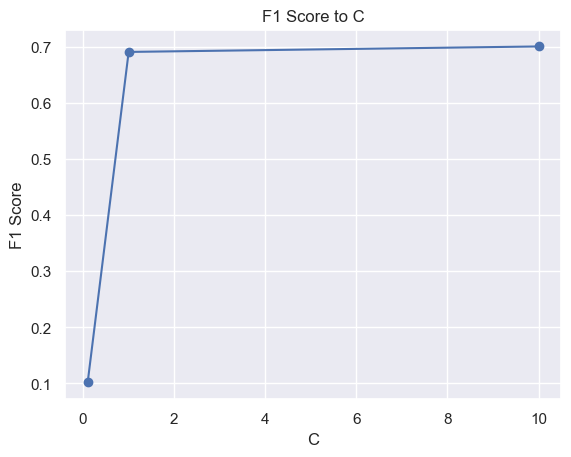

In [41]:
results = svc.cv_results_

mean_test_f1 = results['mean_test_score']
params = results['param_C'] 
plt.plot(params, mean_test_f1, marker='o')
plt.xlabel('C')
plt.ylabel('F1 Score')
plt.title('F1 Score to C')
plt.grid(True)
plt.show()

In [48]:
results = lg.cv_results_
mean_test_f1 = results['mean_test_score']
params = results['params']

unique_beta = sorted(set(p['beta'] for p in params))
f1_scores = [np.mean([mean_test_f1[i] for i, p in enumerate(params) if p['beta'] == value]) for value in unique_beta_values]
plt.plot(unique_beta, f1_scores_for_beta, marker='o')
plt.xlabel('Beta')
plt.ylabel('F1 Score')
plt.title('F1 Score to beta')
plt.grid(True)
plt.show()

unique_gamma = sorted(set(p['gamma'] for p in params))
f1_scores = [np.mean([mean_test_f1[i] for i, p in enumerate(params) if p['gamma'] == value]) for value in unique_gamma_values]
plt.plot(unique_gamma, f1_scores_for_gamma, marker='o')
plt.xlabel('Gamma')
plt.ylabel('F1 Score')
plt.title('F1 Score to gamma')
plt.grid(True)
plt.show()

# Plot for lr
plt.figure(figsize=(8, 6))
unique_lr = sorted(set(p['lr'] for p in params))
f1_scores = [np.mean([mean_test_f1[i] for i, p in enumerate(params) if p['lr'] == value]) for value in unique_lr_values]
plt.plot(unique_lr, f1_scores, marker='o')
plt.xlabel('Learning rate')
plt.ylabel('F1 Score')
plt.title('F1 Score to learing rate')
plt.grid(True)
plt.show()

NameError: name 'unique_beta_values' is not defined

In [49]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

In [50]:
y_pred_svc = svc.predict(X_test)

cm_svc = confusion_matrix(y_test, y_pred_svc)
ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.title('Confusion Matrix for SVC')

KeyboardInterrupt: 

Text(0.5, 1.0, 'Confusion Matrix for logistic regression')

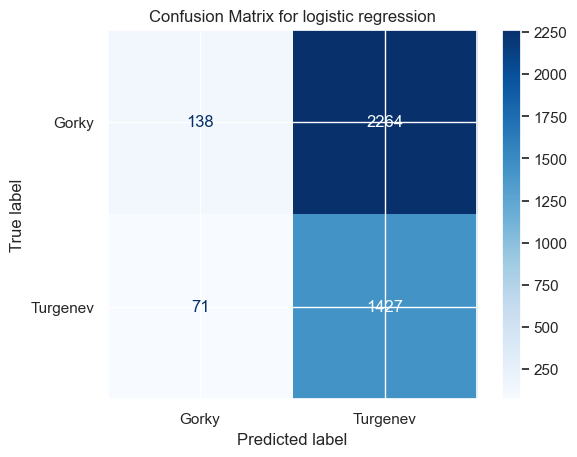

In [51]:
y_pred_lg = lg.predict(X_test)

cm_lg = confusion_matrix(y_test, y_pred_lg)
ConfusionMatrixDisplay(confusion_matrix=cm_lg, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.title('Confusion Matrix for logistic regression')

На матрице SVC можно увидеть что большая часть предсказаний оказывается верной, хотя модель достаточно часто предсказывает Горького и в случае строк Тургенева.

Говоря же о модели логистической регрессии, здесь дела гораздо хуже, ибо модель в подавляющем большинстве случаев на все строки ставит штамп "Горький". При этом F1-Score выходит неплохой, что частично может обуславливать такой исход - если метрика получается нормальной, то значит все работает правильно.

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

*It is possible to use sklearn model instead of your own one but with a penalty of 0.5*

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute relevant metrics for test sample (use sklearn)

In [ ]:
# your code here